# Candidate Generation and LGBM

## 1. Setup and imports

* pip install pyarrow (for loading parquets)
* pip install lightgbm (May require installation of other packages: https://github.com/microsoft/LightGBM/tree/master/python-package)

In [1]:
import pandas as pd
import matplotlib as plt
import numpy as np

from average_precision import apk, mapk

In [2]:
# Helper functions for improving memory
# https://www.kaggle.com/c/h-and-m-personalized-fashion-recommendations/discussion/308635
def hex_id_to_int(str):
    return int(str[-16:], 16)

def customer_hex_id_to_int(series):
    return series.str[-16:].apply(hex_id_to_int)

All categorical columns in transactions, customers, and articles have been converted into a numerical code within the saved parquet. All NaN values were replaced with -1. LGBM models perform best when the categorical columns are encoded as integers. 

## 2. Load data

Code for running the subsetted validation set

In [3]:
collab_sample = 0.01
sample = 0.05
MIN_TRANSACTIONS = 0

In [4]:
transactions_train = pd.read_parquet(f'data/transactions_train_sample{sample}_gt{MIN_TRANSACTIONS}transactions.parquet')
customers = pd.read_parquet(f'data/customers_train_sample{sample}_gt{MIN_TRANSACTIONS}transactions.parquet')
articles_train = pd.read_parquet(f'data/articles_train_sample{sample}_gt{MIN_TRANSACTIONS}transactions.parquet')

transactions_val = pd.read_parquet(f'data/transactions_val_sample{sample}_gt{MIN_TRANSACTIONS}transactions.parquet')
articles_val = pd.read_parquet(f'data/articles_val_sample{sample}_gt{MIN_TRANSACTIONS}transactions.parquet')

In [5]:
transactions = pd.concat([transactions_train, transactions_val])

In [6]:
articles = pd.concat([articles_train, articles_val]).drop_duplicates()

Code for running the entire validation set

In [7]:
# transactions_train = pd.read_parquet('data/transactions_train_sample_gt0transactions.parquet')
# transactions_val = pd.read_parquet('data/transactions_val.parquet')

# customers = pd.read_parquet('data/customers.parquet')
# articles = pd.read_parquet('data/articles.parquet')

# transactions = pd.concat([transactions_train, transactions_val])

### Transactions data

In [8]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
0,2018-09-20,1728846800780188,519773001,0.028458,2,0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0
4,2018-09-20,36332863954980556,685687003,0.016932,2,0


In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1568256 entries, 0 to 12320
Data columns (total 6 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1568256 non-null  datetime64[ns]
 1   customer_id       1568256 non-null  uint64        
 2   article_id        1568256 non-null  int32         
 3   price             1568256 non-null  float32       
 4   sales_channel_id  1568256 non-null  int8          
 5   week              1568256 non-null  int8          
dtypes: datetime64[ns](1), float32(1), int32(1), int8(2), uint64(1)
memory usage: 50.9 MB


Number of transactions made per week

<AxesSubplot:title={'center':'Number of Transactions per Week'}>

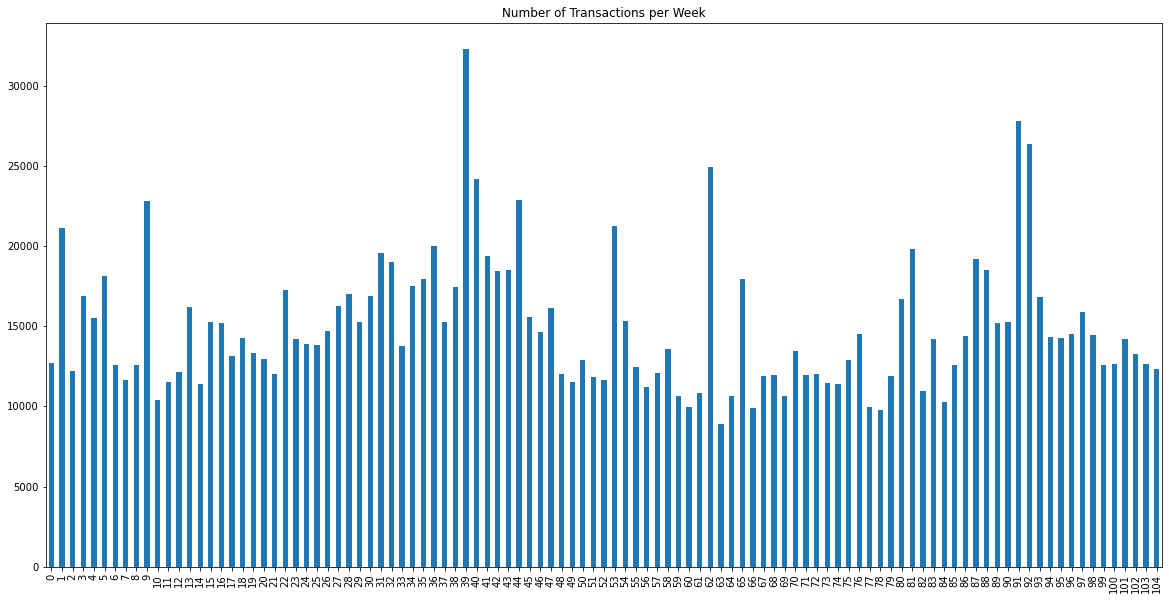

In [10]:
transactions['week']\
    .value_counts()\
    .sort_index()\
    .plot(figsize = (20, 10), kind='bar', title = 'Number of Transactions per Week')

## 5. Train, validation, test split

"Leave One Last Item" train, validation, test split from https://arxiv.org/pdf/2007.13237.pdf

TODO - Make sure Marina's collaborative filtering only uses the data from the train transactions

In [11]:
val_week = transactions["week"].max() # Last week in the training set

# train/ val transactions sets
train_transactions = transactions[transactions["week"] != val_week] 
val_transactions = transactions[transactions["week"] == val_week].reset_index(drop = True)

In [12]:
train_transactions.shape

(1555935, 6)

In [13]:
val_transactions.shape

(12321, 6)

## 6. Candidate Generation

df with each customers last transaction. This will be the base df that we will merge all generated candidates into

In [14]:
# The transaction of each customers last transaction
unique_customers = transactions \
    .groupby(['customer_id']) \
    .tail(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()
unique_customers['week'].value_counts()

104    3508
103    2874
102    2691
101    2556
100    2031
       ... 
26      264
49      250
24      245
14      233
25      225
Name: week, Length: 105, dtype: int64

### 6.1 Collaborative Filtering Results

Read collaborative filtering csv results

In [15]:
customers_rec_articles = pd.read_csv(f'customers_recommended_articles_sample{collab_sample}.csv')
customers_rec_articles.head()

,customer_id,recom_articles
0,345001598676045,"[875316001, 850176002, 778064003, 841383002, 6..."
1,1845857727772358,"[790096001, 790096002, 605106006, 715303001, 7..."
2,1951136007097426,"[300024064, 737040001, 824752001, 706016003, 6..."
3,2100196506917948,"[720635008, 355072001, 680262018, 864928001, 7..."
4,2163812782565753,"[835136002, 708352003, 794389001, 824085001, 7..."


In [16]:
customers_rec_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13561 entries, 0 to 13560
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     13561 non-null  uint64
 1   recom_articles  13561 non-null  object
dtypes: object(1), uint64(1)
memory usage: 212.0+ KB


Merge the recommended articles with the transaction data to generate negative samples

In [17]:
collab_candidates = pd.merge(
    unique_customers, # base df to merge all results into
    customers_rec_articles, # collaborative filtering results
    on='customer_id'
)

collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,recom_articles
0,2018-09-20,2819150048902023718,2,0,"[355072001, 355072002, 508544003, 472064004, 6..."
1,2018-09-20,3184604665002181925,2,0,"[775624001, 705416001, 581363010, 714790017, 4..."
2,2018-09-20,7282250746421036237,1,0,"[870304001, 870304002, 706016003, 698880001, 8..."
3,2018-09-20,9325328092670889774,1,0,"[681174016, 824448001, 579541001, 826197001, 7..."
4,2018-09-20,10338610707079638146,1,0,"[351484033, 679280004, 595696005, 322017029, 5..."


recom_articles column is a list as a *string* type. Use json (as shown below) to convert the data into a list (of list type) as desired

In [18]:
import json
collab_candidates['recom_articles'] = collab_candidates['recom_articles'].apply(lambda x: json.loads(x))

Create one row per customer_id, article_id combination

In [19]:
collab_candidates = collab_candidates.explode('recom_articles').reset_index(drop=True)

# rename recom_articles to article_id to match other schema
collab_candidates['article_id'] = collab_candidates['recom_articles'] 
collab_candidates = collab_candidates.drop('recom_articles', axis = 1)

collab_candidates.head()

,t_dat,customer_id,sales_channel_id,week,article_id
0,2018-09-20,2819150048902023718,2,0,355072001
1,2018-09-20,2819150048902023718,2,0,355072002
2,2018-09-20,2819150048902023718,2,0,508544003
3,2018-09-20,2819150048902023718,2,0,472064004
4,2018-09-20,2819150048902023718,2,0,651221002


In [20]:
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098557 entries, 0 to 1098556
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1098557 non-null  datetime64[ns]
 1   customer_id       1098557 non-null  uint64        
 2   sales_channel_id  1098557 non-null  int8          
 3   week              1098557 non-null  int8          
 4   article_id        1098284 non-null  object        
dtypes: datetime64[ns](1), int8(2), object(1), uint64(1)
memory usage: 27.2+ MB


Address format of article_id. Drop null rows and convert strings to the correct article_id format

In [21]:
def article_id_str_to_int(series):
    return series.astype('int32')

collab_candidates = collab_candidates.dropna()

collab_candidates['article_id'] = article_id_str_to_int(collab_candidates['article_id'])
collab_candidates.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098284 entries, 0 to 1098556
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   t_dat             1098284 non-null  datetime64[ns]
 1   customer_id       1098284 non-null  uint64        
 2   sales_channel_id  1098284 non-null  int8          
 3   week              1098284 non-null  int8          
 4   article_id        1098284 non-null  int32         
dtypes: datetime64[ns](1), int32(1), int8(2), uint64(1)
memory usage: 31.4 MB


TODO? Approach 1: Identify items that customers last purchased

TODO - Approach 2: Bestsellers/ Popular candidates - identify the top 12 bestselling articles per week

## 3. Combining transactions and candidates / negative examples

Label all transactions that actually occurred as 1 (positive samples)

Comment from Pawel in Kaggle discussion here: https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/307288
In my setting I propose to convert the problem to a table where you have a list of item candidates and you mark the sales as either 0 or 1 depending whether the item was sold in the <b>next</b> week. 

Imagine you want to create negative samples as a list of 1000 most popular items in the last week. Some of those items will be bought by the customers. So the table you need to create is:
customer_id
label = whether it was bought or not
article_id from the list of 1000 most popular items
I'm not saying this is the best approach here but it is more or less what I'm doing. This is a technique where you create a set of explicit negative items. There are also techniques for implicit recommendations but all of them assume some sort of a strategy to generate negative samples.

Positive samples, all previously purchased transactions

In [22]:
transactions["purchased"] = 1 
transactions.shape

(1568256, 7)

Combine positive and negative samples

In [23]:
data = pd.concat([transactions, collab_candidates])
data.purchased.fillna(0, inplace=True) # Label all candidate generated transactions as 0

In [24]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0
4,2018-09-20,36332863954980556,685687003,0.016932,2,0,1.0


TODO - logic here with how lgbm works. It drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples


In [25]:
# Drops duplicates. Retains the transactions (positive labels). If duplicated, will drop the duplicates in the negative samples
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True) 
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0
4,2018-09-20,36332863954980556,685687003,0.016932,2,0,1.0


TODO - add bestseller information see ranking_example.ipynb

Create a joined dataset with transaction, article, and customer information + target values (0/ 1)

In [26]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [27]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [28]:
data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0,519773,7147,245,...,0,15,0,1003,3,10231,0,0,59.0,44730
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0,578472,37340,263,...,0,19,40,1007,9,26053,0,0,59.0,44730
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0,661795,43993,263,...,0,19,40,1007,9,32892,0,0,55.0,18589
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0,684080,1768,262,...,0,19,40,1007,9,6151,0,0,55.0,18589
4,2018-09-23,19275344629630766,655434003,0.101678,2,0,1.0,655434,11138,252,...,0,18,12,1003,3,8607,0,1,51.0,37790


## 4. Train/ Test data

Train data is currently all transactions from weeks 0-103. The target labels are also obtained from transactions from weeks 0-103 (confirm this is correct or whether we should be predicting the next week, ie wk104)

In [29]:
test_week = val_week

In [30]:
test_week

104

In [31]:
train = data[data.week != test_week]
train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,1.0,519773,7147,245,...,0,15,0,1003,3,10231,0,0,59.0,44730
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,1.0,578472,37340,263,...,0,19,40,1007,9,26053,0,0,59.0,44730
2,2018-09-20,2076973761519164,661795002,0.167797,2,0,1.0,661795,43993,263,...,0,19,40,1007,9,32892,0,0,55.0,18589
3,2018-09-20,2076973761519164,684080003,0.101678,2,0,1.0,684080,1768,262,...,0,19,40,1007,9,6151,0,0,55.0,18589
4,2018-09-23,19275344629630766,655434003,0.101678,2,0,1.0,655434,11138,252,...,0,18,12,1003,3,8607,0,1,51.0,37790


In [32]:
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code
2463422,2020-09-22,1951136007097426,778745010,0.033881,1,104,1.0,778745,520,297,...,0,62,31,1017,4,1215,0,0,28.0,150297
2463423,2020-09-22,1951136007097426,300024064,NaN,1,104,0.0,300024,1021,272,...,0,8,17,1009,5,551,0,0,28.0,150297
2463424,2020-09-22,1951136007097426,737040001,NaN,1,104,0.0,737040,2185,252,...,0,6,10,1005,0,992,0,0,28.0,150297
2463425,2020-09-22,1951136007097426,824752001,NaN,1,104,0.0,824752,26971,265,...,0,15,0,1013,8,25470,0,0,28.0,150297
2463426,2020-09-22,1951136007097426,706016003,NaN,1,104,0.0,706016,172,272,...,2,53,1,1009,5,30,0,0,28.0,150297


In [33]:
# Not yet sure what these are
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values
train_baskets

array([2, 2, 3, ..., 1, 3, 1])

Only use a subset of columns specified here as input into the LGBM model

In [34]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code'] #, 'bestseller_rank']

### Model input

In [35]:
train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

In [36]:
train_X.head()

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,club_member_status,fashion_news_frequency,age,postal_code
0,519773001,245,1010010,8,2,12,1626,0,1,15,1003,0,0,59.0,44730
1,578472001,263,1010016,51,1,4,1201,0,1,19,1007,0,0,59.0,44730
2,661795002,263,1010016,12,1,11,1201,0,1,19,1007,0,0,55.0,18589
3,684080003,262,1010010,33,2,18,1201,0,1,19,1007,0,0,55.0,18589
4,655434003,252,1010016,19,4,20,1648,0,1,18,1003,0,1,51.0,37790


In [37]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2463422 entries, 0 to 2463421
Data columns (total 15 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   article_id                  int32  
 1   product_type_no             int32  
 2   graphical_appearance_no     int32  
 3   colour_group_code           int32  
 4   perceived_colour_value_id   int32  
 5   perceived_colour_master_id  int32  
 6   department_no               int32  
 7   index_code                  int8   
 8   index_group_no              int32  
 9   section_no                  int32  
 10  garment_group_no            int32  
 11  club_member_status          int8   
 12  fashion_news_frequency      int8   
 13  age                         float64
 14  postal_code                 int32  
dtypes: float64(1), int32(11), int8(3)
memory usage: 148.0 MB


In [38]:
train_y.value_counts()

1.0    1383577
0.0    1079845
Name: purchased, dtype: int64

## 5. Model training

In [39]:
from lightgbm.sklearn import LGBMRanker

In [40]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [41]:
# not sure what group = train_baskets is for
ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.782045
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.136808
[LightGBM] [Debug] init for col-wise cost 0.040397 seconds, init for row-wise cost 0.054790 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065363 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1101
[LightGBM] [Info] Number of data points in the train set: 2463422, number of used features: 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13


In [42]:
# Obtain feature importances
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

article_id 0.5918667876752887
index_group_no 0.07458186656537219
club_member_status 0.07009220408083082
department_no 0.06005502893005594
postal_code 0.05293408975408517
section_no 0.052807516829862934
age 0.03918698329340267
garment_group_no 0.03240575694921953
index_code 0.019003169768062652
product_type_no 0.007066596153819411
fashion_news_frequency 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
colour_group_code 0.0
graphical_appearance_no 0.0


## 6. Calculate predictions

In [43]:
# Predict on test_X
# Add the predictions to the test data (with customer and article id)
test['preds'] = ranker.predict(test_X)
test.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,product_code,prod_name,product_type_no,...,section_no,section_name,garment_group_no,garment_group_name,detail_desc,club_member_status,fashion_news_frequency,age,postal_code,preds
2463422,2020-09-22,1951136007097426,778745010,0.033881,1,104,1.0,778745,520,297,...,62,31,1017,4,1215,0,0,28.0,150297,-0.004112
2463423,2020-09-22,1951136007097426,300024064,NaN,1,104,0.0,300024,1021,272,...,8,17,1009,5,551,0,0,28.0,150297,-0.014396
2463424,2020-09-22,1951136007097426,737040001,NaN,1,104,0.0,737040,2185,252,...,6,10,1005,0,992,0,0,28.0,150297,-0.057842
2463425,2020-09-22,1951136007097426,824752001,NaN,1,104,0.0,824752,26971,265,...,15,0,1013,8,25470,0,0,28.0,150297,0.028534
2463426,2020-09-22,1951136007097426,706016003,NaN,1,104,0.0,706016,172,272,...,53,1,1009,5,30,0,0,28.0,150297,-0.051533


In [44]:
# Obtain the products for each customer, based on highest predictions.
c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

# c_id2predicted_article_ids[28847241659200] # predicted articles for person 28847241659200

TODO

In [45]:
# # last weeks best sellers will be used in case fewer than 12 recommendations for a customer are made
# bestsellers_last_week = \
#     bestsellers_previous_week[bestsellers_previous_week.week == bestsellers_previous_week.week.max()]['article_id'].tolist()

## 7. Evaluate results

Mileva has to continue from here. Still figuring out how this code is working.

In [46]:
val_week_purchases_by_cust = pd.read_pickle('data/val_ground_truth.pkl')

In [47]:
apks = []

# If the ranking algorithm proposes fewer than 12 items. Pad with the top best sellers from the previous week
for c_id, gt in val_week_purchases_by_cust.items():
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    apks.append(apk(gt, pred[:12], 12))

np.mean(apks)

0.044914051386672885

## 8. Create submission

In [48]:
sub = pd.read_csv('data/sample_submission.csv')

In [49]:
%%time
preds = []
for c_id in customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    # pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: user 1.54 s, sys: 74.7 ms, total: 1.62 s
Wall time: 1.63 s


In [50]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [51]:
# sub_name = '01_model_submission_dl'
# sub.to_csv(f'data/subs/{sub_name}.csv', index=False)

In [52]:
# !kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f 'data/subs/{sub_name}.csv.gz' -m {sub_name}